# Language Detection Project
### Daniel Botnik & Netanel Moshe Saban

## Imports
This code segment is used to import all the modules, functions and classes that used throughout this notebook

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from pprint import pprint
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

## Functions definitions & Variables initialization
scores - Dictonary that used to store the score for each model  
TEST_SIZE - constant
plot_learning_curve - plots the learning curve of a model  
plot_cross_validation - plots the cross validation of a model according to the parameters  
print_gcv_result - prints the best parameters for a model

In [22]:
scores = {}
TEST_SIZE = 0.4

#taken from scikit learn website
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1,1.0,5)):
    if axes is None:
        axes = plt.subplot()
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples", size=16)
    axes.set_ylabel("Score", size=16)
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes,return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_cross_validation(values,means,stds,scores,title,x_label):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(values, means, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(values, means-2*stds, means+2*stds, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(values, scores, '-o', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(values)
    ax.legend()

def print_gcv_result(model_name,gcv):
    print(f'{model_name} achived the best score: {gcv.best_score_} with the following parameters')
    pprint(gcv.best_params_)

## Preprocessing

### Data Loading & Encoding
Our Dataset, `dataset.csv` contains 19869 samples, each sample is saved as following


|    Word   |       Encoded_word       | Language   |
|-----------|--------------------------|------------|
|   כלום    |    [11 12  6 24]         |  Hebrew    |
|   tract   |    [ 1 20 21  2  1]      |  English   |
|   המשנה   |    [ 5 13 21 14  5]      |  Hebrew    |
|   lonely  |    [25 24 13 19 25  9]   |  English   |

The words have been encoded via the script `decode_data.py`.


Because all the samples need to have common length, therfore we padded zeros at the end of array
untill we have 34,  
why 34? Because ***Supercalifragilisticexpialidocious*** have exactly 34 letters.

In addition we added another column named **encoded_language** that transformed our catgorial **Language** into numbers using **LabelBinarizer** that converted  
Hebrew ---> 1  
English ----> 0

Lastly We Extract into **X** and **y** the values that are relevant to our models.

In [23]:
data = pd.read_csv('dataset.csv')

# The pandas holds a string of the array in the following format '[ 1 20 21  2  1]'
# so we have to convert it into numpy array with length 34.
def convert_to_np_array(s):
    encoded_list = []
    for number in s.replace('[','').replace(']','').split():
        encoded_list.append(int(number))
    while len(encoded_list) < 34:
        encoded_list.append(0)
    return np.array(encoded_list)

data['encoded_word'] = data['encoded_word'].apply(convert_to_np_array)
data['encoded_language'] = LabelBinarizer().fit_transform(data['language'])

X = data['encoded_word']
y = data['encoded_language']

data


,word,encoded_word,language,encoded_language
0,כלום,"[11, 12, 6, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Hebrew,1
1,המשנה,"[5, 13, 21, 14, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Hebrew,1
2,photographers,"[17, 10, 24, 1, 24, 16, 20, 21, 17, 10, 19, 20...",English,0
3,קצינים,"[19, 18, 10, 14, 10, 24, 0, 0, 0, 0, 0, 0, 0, ...",Hebrew,1
4,exemption,"[19, 15, 19, 18, 17, 1, 23, 24, 13, 0, 0, 0, 0...",English,0
...,...,...,...,...
19863,standing,"[4, 1, 21, 13, 3, 23, 13, 16, 0, 0, 0, 0, 0, 0...",English,0
19864,ובניגוד,"[6, 2, 14, 10, 3, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0...",Hebrew,1
19865,deadly,"[3, 19, 21, 3, 25, 9, 0, 0, 0, 0, 0, 0, 0, 0, ...",English,0
19866,הרחיב,"[5, 20, 8, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",Hebrew,1


### Spliting Into Train and Test & Normalization
We divide each encoded value by 29, because the encodings set is [0,29]  
and by dividing each element in the set by 29 we get the desired set [0,1]


In [24]:
X = np.array([_ for _ in X]) / 29
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=TEST_SIZE)

## SciKit Learn Classification Models
In this segement, We will train several models, and test how they preform on our data, at the end we will compare them all thogether

### Decision Tree Classifier
#### Checking which parameters preform the best on our data.

In [28]:
param_grid = {
    'max_depth': range(4,22,2),
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"],
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,10),
    'max_features': ['sqrt', 'log2', None]
    
}
clf = DecisionTreeClassifier()
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train,y_train)
print_gcv_result('Decision Tree Classifier',gcv)

Decision Tree Classifier achived the best score: 0.9312919463087248 with the following parameters
{'criterion': 'entropy',
 'max_depth': 14,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5}


#### The effect max_depth have on the Tree Classifier

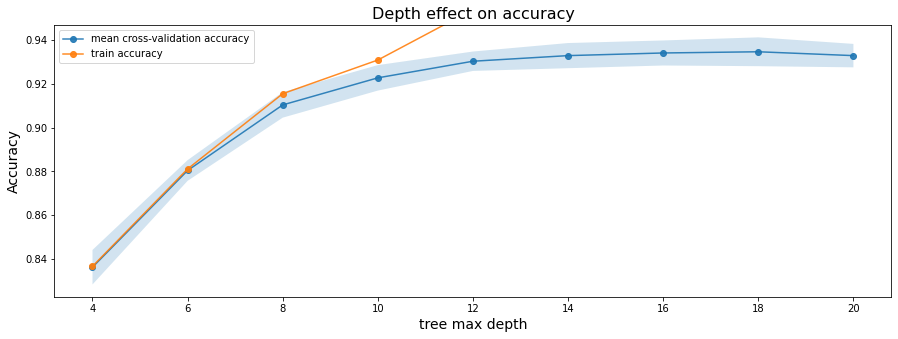

In [11]:
stds = []
means = []
accuracy_scores = []
for depth in range(4,22,2):
    model = DecisionTreeClassifier(max_depth=depth)
    cross_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    means.append(cross_scores.mean())
    stds.append(cross_scores.std())
    accuracy_scores.append(model.fit(X, y).score(X, y))
means = np.array(means)
stds = np.array(stds)
accuracy_scores = np.array(accuracy_scores)
plot_cross_validation(range(4,22,2),means,stds,accuracy_scores,'Depth effect on accuracy','tree max depth')

#### Plotting the learning curve of a Decision Tree Classifier with his optimal parameters

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.931925,0.921998,0.927026,0.926962,0.927066
recall,0.924575,0.929581,0.927026,0.927078,0.927026
f1-score,0.928236,0.925774,0.927026,0.927005,0.927031
support,4057.000000,3891.000000,0.927026,7948.000000,7948.000000


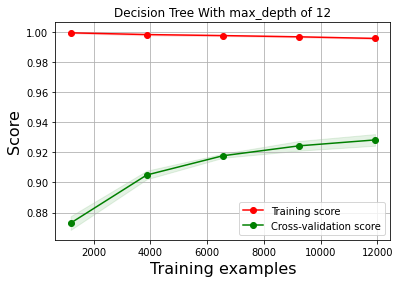

In [12]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_preds=clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['Tree'] = report['accuracy'][0]
plot_learning_curve(clf,'Optimal Decision Tree Classifier',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

#### Save the tree visualtsion into pdf

In [9]:
dot_data = tree.export_graphviz(clf, out_file=None,filled=True, rounded=True, class_names=['Hebrew','English'])
graph = graphviz.Source(dot_data)
graph.render('TreeModel')

'TreeModel.pdf'

### SVC
Because SVC have multiple possbile kernels, we will check for each kernel individually
#### First we use PCA on our data before we fit it into the SVC


In [156]:
pca = PCA(n_components=34).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#### radial basis function kernel
##### Finding the best parameters

In [161]:
param_grid = {
      'C': [0.1,0.5,1,5,10,50,100,1000],
      'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5,10]
    
}
clf = SVC(kernel='rbf')
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train_pca,y_train)
print_gcv_result('SVC Classifier with rbf kernel',gcv)

SVC Classifier with rbf kernel achived the best score: 0.904026845637584 with the following parameters
{'C': 5, 'gamma': 5}


##### The Effect C and gamma have on SVC with rbf kernel

In [160]:
C = [0.1,0.5,1,5,10,50,100,1000],
gamma = [0.0001, 0.001, 0.005, 0.1, 1, 3, 5,10]
accuracy_scores = []
for c in C:
    for g in gamma:
        model = SVC(kernel='rbf',C=c,gamma=g)
        accuracy_scores.append(model.fit(np.concatenate((X_train_pca,X_test_pca)), y).score(np.concatenate((X_train_pca,X_test_pca)), y))
accuracy_scores = np.array(accuracy_scores)
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_title('C and gamma effect on Accuracy',size=16)
ax.set_xlabel('C',size=14)
ax.set_ylabel('gamma',size=14)
ax.set_zlabel('Accuracy',size=14)
ax.plot_wireframe(C,gamma,scores.reshape(8,8))

##### Plotting the learning curve of rbf kernel SVC with his optimal parameters

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.907156,0.875031,0.89079,0.891093,0.891372
recall,0.874845,0.907298,0.89079,0.891072,0.890790
f1-score,0.890708,0.890873,0.89079,0.890790,0.890789
support,4043.000000,3905.000000,0.89079,7948.000000,7948.000000


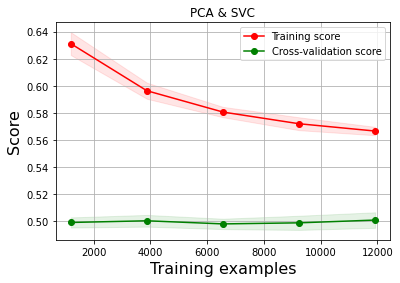

In [7]:
clf = SVC(kernel='rbf')
clf.fit(X_train_pca,y_train)
y_preds = clf.predict(X_test_pca)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['SVC'] = report['accuracy'][0]
plot_learning_curve(clf,'SVC with rbf kernel',np.concatenate((X_train_pca,X_test_pca)),y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

#### Liner kernel
##### Finding the best parameters

#####

In [ ]:
clf = SVC(kernel='liner')
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train,y_train)
print_gcv_result('SVC Classifier with liner kernel',gcv)

##### Showing the effect gamma and C have on the liner kernel

In [ ]:
accuracy_scores = []
for c in C:
    for g in gamma:
        model = SVC(kernel='liner',C=c,gamma=g)
        accuracy_scores.append(model.fit(np.concatenate((X_train_pca,X_test_pca)), y).score(np.concatenate((X_train_pca,X_test_pca)), y))
accuracy_scores = np.array(accuracy_scores)
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_title('C and gamma effect on Accuracy',size=16)
ax.set_xlabel('C',size=14)
ax.set_ylabel('gamma',size=14)
ax.set_zlabel('Accuracy',size=14)
ax.plot_wireframe(C,gamma,accuracy_scores.reshape(8,8),cmap='binary')

##### Plotting the learning curve of liner kernel SVC with his optimal parameters

In [ ]:
clf = SVC(kernel='liner')
clf.fit(X_train_pca,y_train)
y_preds = clf.predict(X_test_pca)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['SVC'] = max(report['accuracy'][0],scores['SVC'])
plot_learning_curve(clf,'SVC with liner kernel',np.concatenate((X_train_pca,X_test_pca)),y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

#### Polynomial kernel
##### Finding the best parameters

In [162]:
param_grid['degree'] = range(2,8)
clf = SVC(kernel='poly')
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train,y_train)
print_gcv_result('SVC Classifier with polynomial kernel',gcv)

##### Showing the effect the degree have on the model


In [ ]:
stds = []
means = []
accuracy_scores = []
for degree in range(2,8):
    model = SVC(kernel='poly',degree=degree)
    cross_scores = cross_val_score(model,np.concatenate((X_train_pca,X_test_pca)) , y, cv=5, scoring='accuracy')
    means.append(cross_scores.mean())
    stds.append(cross_scores.std())
    accuracy_scores.append(model.fit(np.concatenate((X_train_pca,X_test_pca)), y).score(np.concatenate((X_train_pca,X_test_pca)), y))
means = np.array(means)
stds = np.array(stds)
accuracy_scores = np.array(accuracy_scores)
plot_cross_validation(range(4,22,2),means,stds,accuracy_scores,'Polynomial degree effect on accuracy','polynomial degree')

##### Plotting the learning curve of polynomial kernel SVC with his optimal parameters

In [ ]:
clf = SVC(kernel='poly')
clf.fit(X_train_pca,y_train)
y_preds = clf.predict(X_test_pca)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['SVC'] = max(report['accuracy'][0],scores['SVC'])
plot_learning_curve(clf,'SVC with polynomial kernel',np.concatenate((X_train_pca,X_test_pca)),y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### Naive Bayes
#### Finding the best parameters

In [20]:
param_grid = {
    'alpha': np.linspace(0.5, 1.5, 10),
    'fit_prior': [True, False], 
}
clf = MultinomialNB()
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train,y_train)
print_gcv_result('Naive Bayes Classifier',gcv)

Gradient Naive Bayes Classifier achived the best score: 0.6258389261744967 with the following parameters
{'alpha': 1.3, 'fit_prior': True}


#### Showing the effect alpha have on the model

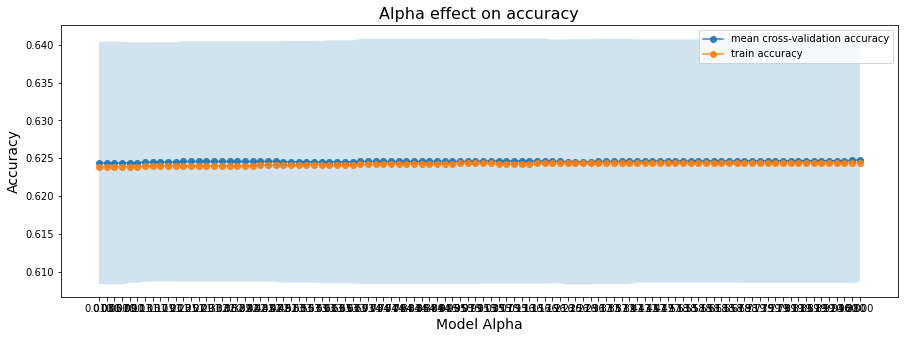

In [17]:
stds = []
means = []
accuracy_scores = []
for alpha in np.linspace(0.5,1.5,10):
    model = MultinomialNB(alpha=alpha)
    cross_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    means.append(cross_scores.mean())
    stds.append(cross_scores.std())
    accuracy_scores.append(model.fit(X, y).score(X, y))
means = np.array(means)
stds = np.array(stds)
accuracy_scores = np.array(accuracy_scores)
plot_cross_validation(np.linspace(0.5,1.5,10),means,stds,accuracy_scores,'Alpha effect on accuracy','Model Alpha')

#### Plotting the learning curve of the model with his optimal parameters

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.757121,0.572558,0.619024,0.664840,0.666767
recall,0.373429,0.875096,0.619024,0.624263,0.619024
f1-score,0.500165,0.692214,0.619024,0.596189,0.594184
support,4057.000000,3891.000000,0.619024,7948.000000,7948.000000


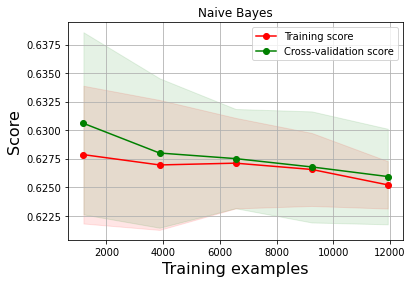

In [18]:
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['Naive Bayes'] = report['accuracy'][0]
plot_learning_curve(clf,'Naive Bayes',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### Stochastic Gradient Descent
#### Finding the best parameters

In [33]:
param_grid = {
    'alpha': [0.001,0.005,0.01,0.05,0.1,0.25,0.5,1], # learning rate
    'loss': ['hinge','log'], # logistic regression,
    'penalty': ['l2','l1'],
}
clf = SGDClassifier(loss='hinge')
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train,y_train)
print_gcv_result('Stochastic Gradient Descent Classifier',gcv)

Stochastic Gradient Descent Classifier achived the best score: 0.7770134228187919 with the following parameters
{'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'}


#### Showing the effect alpha have on the model

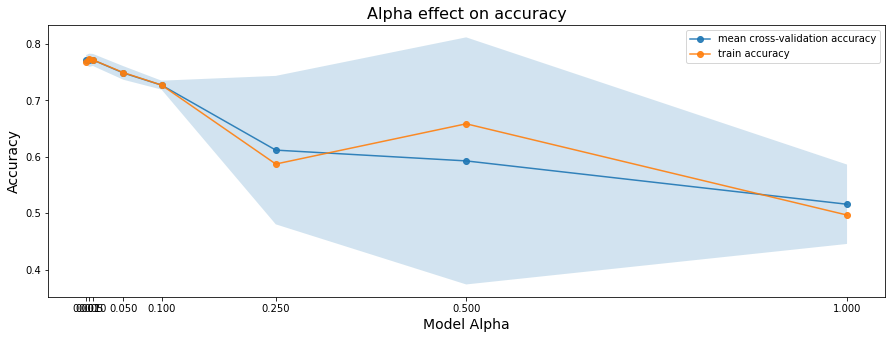

In [21]:
alphas = [0.001,0.005,0.01,0.05,0.1,0.25,0.5,1]
stds = []
means = []
accuracy_scores = []
for alpha in alphas:
    model = SGDClassifier(alpha=alpha)
    cross_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    means.append(cross_scores.mean())
    stds.append(cross_scores.std())
    accuracy_scores.append(model.fit(X, y).score(X, y))
means = np.array(means)
stds = np.array(stds)
accuracy_scores = np.array(accuracy_scores)
plot_cross_validation(np.array(alphas),means,stds,accuracy_scores,'Alpha effect on accuracy','Model Alpha')

#### Plotting the learning curve of the model with the optimal parameters

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.792004,0.756712,0.77315,0.774358,0.774318
recall,0.739470,0.806678,0.77315,0.773074,0.773150
f1-score,0.764836,0.780897,0.77315,0.772867,0.772885
support,3965.000000,3983.000000,0.77315,7948.000000,7948.000000


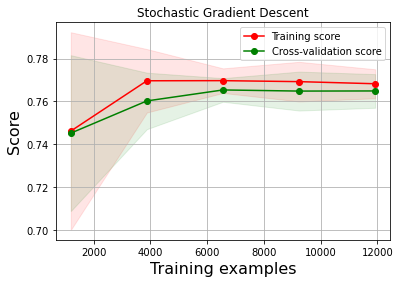

In [28]:
clf = SGDClassifier(loss='hinge')
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['SGD'] = report['accuracy'][0]
plot_learning_curve(clf,'Stochastic Gradient Descent',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### K Nearst Neighbors
#### Finding the best parameters

In [25]:
param_grid = {
    'n_neighbors': range(1, 21, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'] 
}
clf = KNeighborsClassifier()
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train,y_train)
print_gcv_result('K Nearst Neighbors Classifier',gcv)

K Nearst Neighbors Classifier achived the best score: 0.9212248322147651 with the following parameters
{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


#### Showing the effect the number of neighbors have on the model

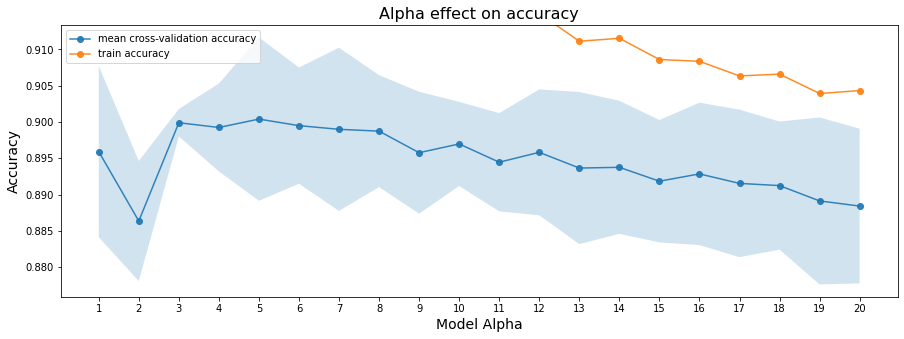

In [24]:
stds = []
means = []
accuracy_scores = []
for n_neighbors in range(1,21,1):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    cross_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    means.append(cross_scores.mean())
    stds.append(cross_scores.std())
    accuracy_scores.append(model.fit(X, y).score(X, y))
means = np.array(means)
stds = np.array(stds)
accuracy_scores = np.array(accuracy_scores)
plot_cross_validation(range(1,21,1),means,stds,accuracy_scores,'Number of neighbors effect on accuracy','Number of Neighbors')

#### Plotting the model learning curve with the optimal parameters

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.910845,0.885457,0.89771,0.898151,0.898122
recall,0.881211,0.914135,0.89771,0.897673,0.897710
f1-score,0.895783,0.899568,0.89771,0.897675,0.897679
support,3965.000000,3983.000000,0.89771,7948.000000,7948.000000


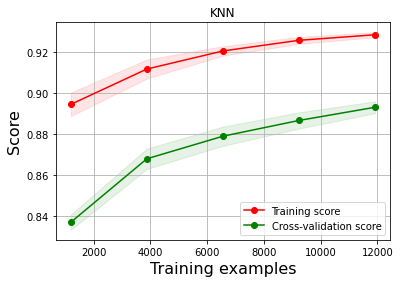

In [32]:
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['KNN'] = report['accuracy'][0]
plot_learning_curve(clf,'KNN',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### Random Forest
#### Finding the best parameters

In [24]:
param_grid = {
    'n_estimators':range(10,210,10),
    'max_depth':[4,6,8,10,12,14],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2],
    'max_features':['sqrt','log2'],
}
clf = RandomForestClassifier()
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train,y_train)
print_gcv_result('Random Forest Classifier',gcv)

Random Forest Classifier achived the best score: 0.9536073825503356 with the following parameters
{'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}


#### Showing the effect the number of estimators have on the model

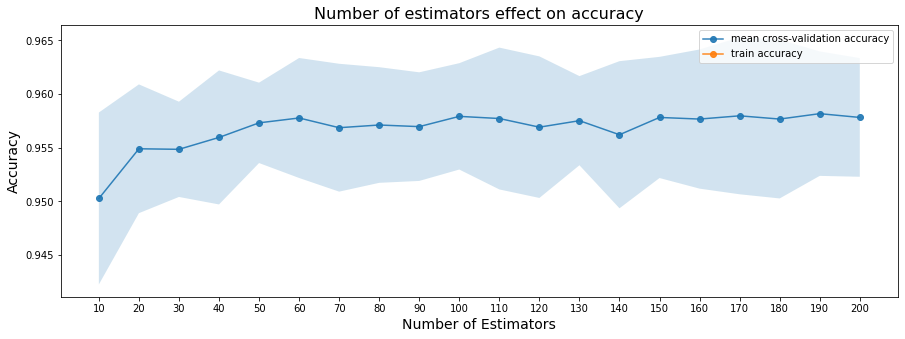

In [26]:
stds = []
means = []
accuracy_scores = []
for n_estimators in range(10,210,10):
    model = RandomForestClassifier(n_estimators=n_estimators)
    cross_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    means.append(cross_scores.mean())
    stds.append(cross_scores.std())
    accuracy_scores.append(model.fit(X, y).score(X, y))
means = np.array(means)
stds = np.array(stds)
accuracy_scores = np.array(accuracy_scores)
plot_cross_validation(range(10,210,10),means,stds,accuracy_scores,'Number of estimators effect on accuracy','Number of Estimators')

#### Plotting the learning curve of the model with the optimal parameters

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.965821,0.938326,0.951686,0.952073,0.952101
recall,0.936715,0.966717,0.951686,0.951716,0.951686
f1-score,0.951045,0.952310,0.951686,0.951678,0.951676
support,3982.000000,3966.000000,0.951686,7948.000000,7948.000000


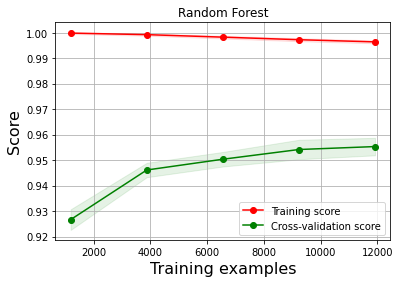

In [26]:
clf = RandomForestClassifier(max_depth=14,max_features='sqrt',min_samples_leaf=1,min_samples_split=2,n_estimators=100)
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['Random Forest'] = report['accuracy'][0]
plot_learning_curve(clf,'Random Forest',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

### Gradient Boosting

#### Finding the best parameters

In [ ]:
param_grid = {
    'max_depth':range(5,15),
    'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.25,0.5,1],
    'n_estimators':range(50,210,10),
    'max_features':['sqrt','log2'],
    'sub_sample': [(i / 10) for i in range(5,11,1)]
}
clf = GradientBoostingClassifier()
gcv = GridSearchCV(clf,param_grid,cv=5,n_jobs=-1)
gcv.fit(X_train,y_train)
print_gcv_result('Gradient Boosting Classifier',gcv)

#### Showing the effect max_depth have on the model

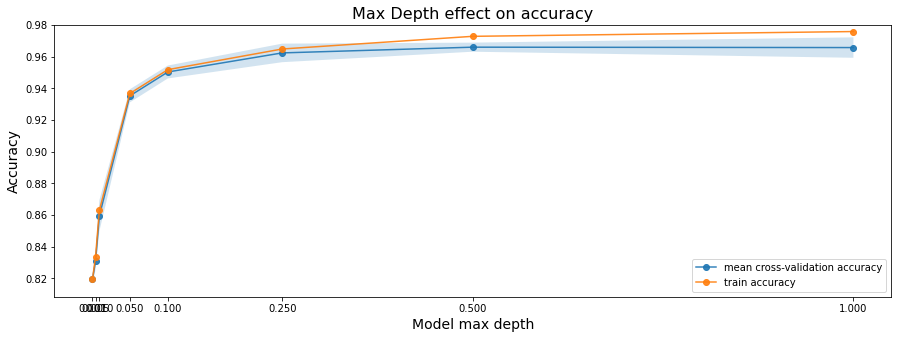

In [31]:
stds = []
means = []
accuracy_scores = []
for depth in range(5,15):
    model = GradientBoostingClassifier(max_depth=depth)
    cross_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    means.append(cross_scores.mean())
    stds.append(cross_scores.std())
    accuracy_scores.append(model.fit(X, y).score(X, y))
means = np.array(means)
stds = np.array(stds)
accuracy_scores = np.array(accuracy_scores)
plot_cross_validation(np.array(range(5,15)),means,stds,accuracy_scores,'Max Depth effect on accuracy','Model max depth')

#### Plotting the learning curve of the model with the optimal parameters

,Hebrew,English,accuracy,macro avg,weighted avg
precision,0.956793,0.960700,0.958732,0.958747,0.958741
recall,0.961114,0.956335,0.958732,0.958725,0.958732
f1-score,0.958949,0.958513,0.958732,0.958731,0.958731
support,3986.000000,3962.000000,0.958732,7948.000000,7948.000000


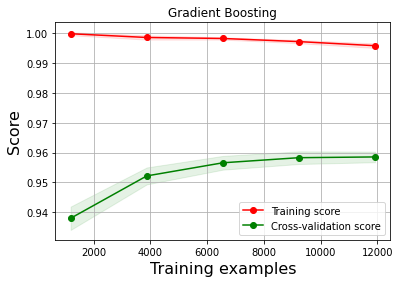

In [14]:
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
y_preds = clf.predict(X_test)
report = pd.DataFrame(classification_report(y_test,y_preds,target_names=['Hebrew','English'],output_dict=True))
scores['Boosting'] = report['accuracy'][0]
plot_learning_curve(clf,'Gradient Boosting',X,y,cv=ShuffleSplit(test_size=TEST_SIZE))
report

## Models Summary
compression of the models accruacy

<BarContainer object of 7 artists>

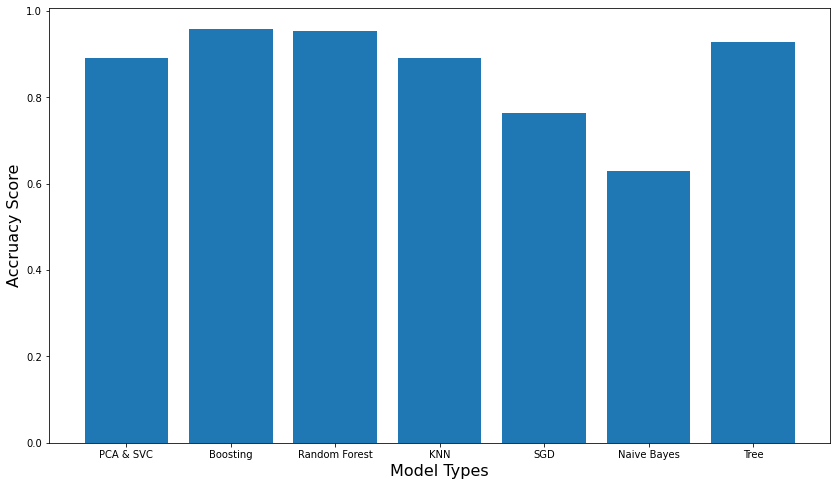

In [62]:
fig=plt.figure(figsize=(14,8),)
plt.xlabel('Model Types',size=16)
plt.ylabel('Accruacy Score',size=16)
plt.bar(*zip(*scores.items()),figure=fig)

As we can see from the graph Gradient Boosting Classifier works the best for our usage with more then 95% of accruacy!

## Neural Networks - Tensorflow

### Check for GPU processing

In [12]:
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

### Prepartions
while scikit-learn **LabelBinarizer** converted our categorial output values to zeros and ones, tensorflow output needs to be different

In [14]:

_y_train = tf.keras.utils.to_categorical(y_train,num_classes=2)
_y_test = tf.keras.utils.to_categorical(y_test,num_classes=2)

### Normal Network

In [41]:

adam = Adam()

_y_train = tf.keras.utils.to_categorical(y_train,num_classes=2)
_y_test = tf.keras.utils.to_categorical(y_test,num_classes=2)

model = tf.keras.Sequential([
    InputLayer(input_shape=(34,)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dropout(0.3),
    Dense(34),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
],name='Model')

model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
history = model.fit(X_train,_y_train, epochs=150,validation_data=(X_test, _y_test), batch_size=1024)


Epoch 1/150
12/12 [==============================] - 0s 11ms/step - loss: 0.6804 - accuracy: 0.5381 - val_loss: 0.6696 - val_accuracy: 0.5184
Epoch 2/150
12/12 [==============================] - 0s 5ms/step - loss: 0.6577 - accuracy: 0.5615 - val_loss: 0.6452 - val_accuracy: 0.5910
Epoch 3/150
12/12 [==============================] - 0s 5ms/step - loss: 0.6313 - accuracy: 0.6365 - val_loss: 0.6116 - val_accuracy: 0.6988
Epoch 4/150
12/12 [==============================] - 0s 5ms/step - loss: 0.5986 - accuracy: 0.7035 - val_loss: 0.5798 - val_accuracy: 0.7253
Epoch 5/150
12/12 [==============================] - 0s 5ms/step - loss: 0.5708 - accuracy: 0.7171 - val_loss: 0.5522 - val_accuracy: 0.7409
Epoch 6/150
12/12 [==============================] - 0s 5ms/step - loss: 0.5450 - accuracy: 0.7296 - val_loss: 0.5274 - val_accuracy: 0.7548
Epoch 7/150
12/12 [==============================] - 0s 5ms/step - loss: 0.5200 - accuracy: 0.7520 - val_loss: 0.5057 - val_accuracy: 0.7657
Epoch 8/150


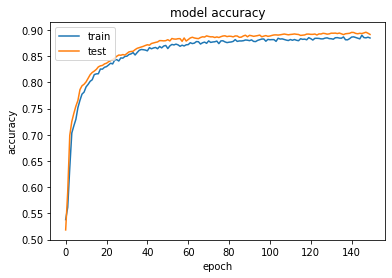

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()

### Convolutional Network

In [35]:
adam = Adam()

_X_train = X_train.reshape(len(X_train),34,1)
_X_test = X_test.reshape(len(X_test),34,1)

model = tf.keras.Sequential([
    Input(shape=(34,1)),
    Conv1D(20,kernel_size=5,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    Conv1D(40,kernel_size=5,strides=2,padding='same',activation='relu'),
    BatchNormalization(),
    Conv1D(60,kernel_size=6,strides=2,padding='same',activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(200),
    Activation('relu'),
    Dropout(0.3),
    Dense(100),
    Activation('relu'),
    BatchNormalization(),
    Dense(2),
    Activation('softmax')
],name='myModel')

model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
history = model.fit(_X_train,_y_train, epochs=150,validation_data=(_X_test, _y_test), batch_size=512,verbose=1)

Epoch 1/400
39/39 [==============================] - 1s 17ms/step - loss: 0.3839 - accuracy: 0.8334 - val_loss: 0.7880 - val_accuracy: 0.4774
Epoch 2/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2683 - accuracy: 0.8883 - val_loss: 0.9299 - val_accuracy: 0.4774
Epoch 3/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2463 - accuracy: 0.8940 - val_loss: 1.1008 - val_accuracy: 0.4774
Epoch 4/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2326 - accuracy: 0.9033 - val_loss: 1.4726 - val_accuracy: 0.4774
Epoch 5/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2252 - accuracy: 0.9043 - val_loss: 1.7343 - val_accuracy: 0.4774
Epoch 6/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2141 - accuracy: 0.9088 - val_loss: 2.1241 - val_accuracy: 0.4774
Epoch 7/400
39/39 [==============================] - 0s 10ms/step - loss: 0.2037 - accuracy: 0.9118 - val_loss: 2.5566 - val_accuracy: 0.4774
Epoch 

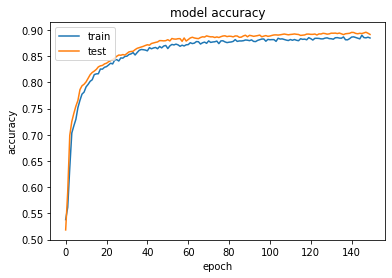

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()

### Save the Normal Model